# Australian Rooftop Photovoltaic (PV) Energy Data

This notebook describes the provenance of **actual** rooftop PV energy production for Australian states, as prepared and distributed by AEMO. 

Details are described here:
https://aemo.com.au/en/energy-systems/electricity/national-electricity-market-nem/nem-forecasting-and-planning/operational-forecasting/solar-and-wind-energy-forecasting/australian-solar-energy-forecasting-system

Rooftop PV production is measured using two different methods:
    - Satellite data
    - Self-reported actual measurements

The datasets for each measurement method are dealt with separately throughout.

### Data source, downloading and unzipping
Data is available at these URLs.

- Current actual PV measurements:
http://nemweb.com.au/Reports/CURRENT/ROOFTOP_PV/ACTUAL/

- Archived actual PV measurements:
http://nemweb.com.au/Reports/ARCHIVE/ROOFTOP_PV/ACTUAL/

The data is presented as individual .CSV files, each compressed into a .ZIP archive. All data for both CURRENT and ARCHIVE datasets was downloaded to the local workstation using the *wget* command:
    example: wget -r -np http://nemweb.com.au/Reports/CURRENT/ROOFTOP_PV/ACTUAL/

Individual .CSV files were unzipped, and merged together into a set of 4  large .CSV files:

### .CSV file merging and pre-processing

Preprocessing commands:

For current MEASUREMENT files
1: head -2 ./current/PUBLIC_ROOFTOP_PV_ACTUAL_MEASUREMENT_20220305093000_0000000358943236.csv | tail -n 1 > current_measurement.csv
2: gtail --quiet -n +3  ./current/*MEASUREMENT*.csv | sed '/END OF REPORT/d' >> current_measurement.csv

For current SATELLITE files
head -2 ./current/PUBLIC_ROOFTOP_PV_ACTUAL_SATELLITE_20220305160000_0000000358958976.csv | tail -n 1 > current_satellite.csv

For archive files, the number of files to process was too large if attempted all in one go. File lists were split up by methodology and year.
- For archive SATELLITE files
head -2 ./archive/PUBLIC_ROOFTOP_PV_ACTUAL_SATELLITE_20220216080000_0000000357965347.csv | tail -n 1 > archive_satellite.csv
gtail --quiet -n +3  ./archive/*SATELLITE_2021*.csv | sed '/END OF REPORT/d' >> archive_satellite.csv
gtail --quiet -n +3  ./archive/*SATELLITE_2022*.csv | sed '/END OF REPORT/d' >> archive_satellite.csv

- For archive MEASUREMENT files
head -2 ./archive/PUBLIC_ROOFTOP_PV_ACTUAL_MEASUREMENT_20211229233000_0000000355230540.csv | tail -n 1 > archive_measurement.csv
gtail --quiet -n +3  ./archive/*MEASUREMENT_2021*.csv | sed '/END OF REPORT/d' >> archive_measurement.csv
gtail --quiet -n +3  ./archive/*MEASUREMENT_2022*.csv | sed '/END OF REPORT/d' >> archive_measurement.csv

All processing was performed on a macOS 11.6.3 system, with GNU *gtail* and *ghead* utilities obtained from the brew *coreutils* package

In [46]:
import pandas as pd
import seaborn as sns


In [39]:
# Load the archive and current datasets for both direct measurement and satellite rooftop PV
DATA_PATH = "../../data/rooftop_pv/"

archive_measurement_df = pd.read_csv(DATA_PATH+"archive_measurement.csv")
archive_satellite_df = pd.read_csv(DATA_PATH+"archive_satellite.csv")
current_measurement_df = pd.read_csv(DATA_PATH+"current_measurement.csv")
current_satellite_df = pd.read_csv(DATA_PATH+"current_satellite.csv")


In [40]:
# Merge the archive and current satellite, and the archive and current direct measurement.
satellite_merge_df = pd.concat([current_satellite_df, archive_satellite_df])
measurement_merge_df = pd.concat([current_measurement_df, archive_measurement_df])

# Convert the INTERVAL_DATETIME fields to Pandas datetime format for sorting.
satellite_merge_df.INTERVAL_DATETIME = pd.to_datetime(satellite_merge_df.INTERVAL_DATETIME)
measurement_merge_df.INTERVAL_DATETIME = pd.to_datetime(measurement_merge_df.INTERVAL_DATETIME)



Examine datatypes and check that the datetime conversion of INTERVAL_DATETIME has been successful.

In [73]:
measurement_merge_df.head(5)


,I,ROOFTOP,ACTUAL,2,INTERVAL_DATETIME,REGIONID,POWER,QI,TYPE,LASTCHANGED
6,D,ROOFTOP,ACTUAL,2,2021-01-20 23:30:00,TAS1,0.0,1.0,MEASUREMENT,2021/01/20 23:50:19
8,D,ROOFTOP,ACTUAL,2,2021-01-20 23:30:00,TASS,0.0,1.0,MEASUREMENT,2021/01/20 23:50:19
0,D,ROOFTOP,ACTUAL,2,2021-01-20 23:30:00,NSW1,0.0,1.0,MEASUREMENT,2021/01/20 23:50:19
1,D,ROOFTOP,ACTUAL,2,2021-01-20 23:30:00,QLD1,0.0,1.0,MEASUREMENT,2021/01/20 23:50:19
2,D,ROOFTOP,ACTUAL,2,2021-01-20 23:30:00,QLDC,0.0,1.0,MEASUREMENT,2021/01/20 23:50:19


- INTERVAL_DATETIME	The forecast half-hour interval (time ending)	DATE
- TYPE	One of DAILY, MEASUREMENT or SATELLITE. DAILY- best quality estimated actuals, available day after. MEASUREMENT- best quality estimated actuals on day, delayed by 1 half hour. SATELLITE- estimated actuals using satellite imagery, delayed by 1 half hour.	VARCHAR2(20)
- REGIONID	Region identifier	VARCHAR2
- POWER	Estimated generation in MW at the interval end	NUMBER(12,3)
- QI	Quality indicator. Represents the quality of the estimate.	NUMBER(2,1)
- LASTCHANGED	Last date and time record changed	DATE

In [65]:
satellite_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123780 entries, 0 to 2879
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   I                  123780 non-null  object        
 1   ROOFTOP            123780 non-null  object        
 2   ACTUAL             123780 non-null  object        
 3   2                  123780 non-null  int64         
 4   INTERVAL_DATETIME  123780 non-null  datetime64[ns]
 5   REGIONID           123780 non-null  object        
 6   POWER              123780 non-null  float64       
 7   QI                 123780 non-null  float64       
 8   TYPE               123780 non-null  object        
 9   LASTCHANGED        123780 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 10.4+ MB


In [68]:

satellite_merge_df.groupby(['REGIONID']).describe()

2                                       POWER              \
            count mean  std  min  25%  50%  75%  max    count        mean   
REGIONID                                                                    
NSW1      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0  527.678697   
QLD1      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0  603.426926   
QLDC      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0   60.568295   
QLDN      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0  100.919926   
QLDS      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0  441.938706   
SA1       12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0  256.390428   
TAS1      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0   24.176044   
TASN      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0   14.028766   
TASS      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0   10.147280   
VIC1      12378.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  12378.0  389.843324   

          ...                             QI                               \
          ...         75%       max    count mean           std  min  25%   
REGIONID  ...                                                               
NSW1      ...   970.35200  3157.737  12378.0  0.6  1.110268e-16  0.6  0.6   
QLD1      ...  1149.90775  3426.647  12378.0  0.6  1.110268e-16  0.6  0.6   
QLDC      ...   114.82050   327.950  12378.0  0.6  1.110268e-16  0.6  0.6   
QLDN      ...   186.40275   541.414  12378.0  0.6  1.110268e-16  0.6  0.6   
QLDS      ...   832.84375  2585.466  12378.0  0.6  1.110268e-16  0.6  0.6   
SA1       ...   442.29675  1487.357  12378.0  0.6  1.110268e-16  0.6  0.6   
TAS1      ...    40.41950   164.004  12378.0  0.6  1.110268e-16  0.6  0.6   
TASN      ...    23.31475    92.097  12378.0  0.6  1.110268e-16  0.6  0.6   
TASS      ...    15.93650    72.884  12378.0  0.6  1.110268e-16  0.6  0.6   
VIC1      ...   647.32500  2532.528  12378.0  0.6  1.110268e-16  0.6  0.6   

                         
          50%  75%  max  
REGIONID                 
NSW1      0.6  0.6  0.6  
QLD1      0.6  0.6  0.6  
QLDC      0.6  0.6  0.6  
QLDN      0.6  0.6  0.6  
QLDS      0.6  0.6  0.6  
SA1       0.6  0.6  0.6  
TAS1      0.6  0.6  0.6  
TASN      0.6  0.6  0.6  
TASS      0.6  0.6  0.6  
VIC1      0.6  0.6  0.6  

[10 rows x 24 columns]

In [72]:
satellite_merge_df['QI'].unique()

array([0.6])

In [45]:
# Sort by INTERVAL_DATETIME in ascending order and write out to .CSV

satellite_merge_df = satellite_merge_df.sort_values(by='INTERVAL_DATETIME', ascending=True)
measurement_merge_df = measurement_merge_df.sort_values(by='INTERVAL_DATETIME', ascending=True)

# .CSV files are written, this section now commented out.
#satellite_merge_df.to_csv(DATA_PATH+"rooftop_pv_satellite.csv")
#measurement_merge_df.to_csv(DATA_PATH+"rooftop_pv_measurement.csv")

## Simple EDA: plotting daily PV production in NSW for year-to-date (2022)

<AxesSubplot:xlabel='INTERVAL_DATETIME', ylabel='POWER'>

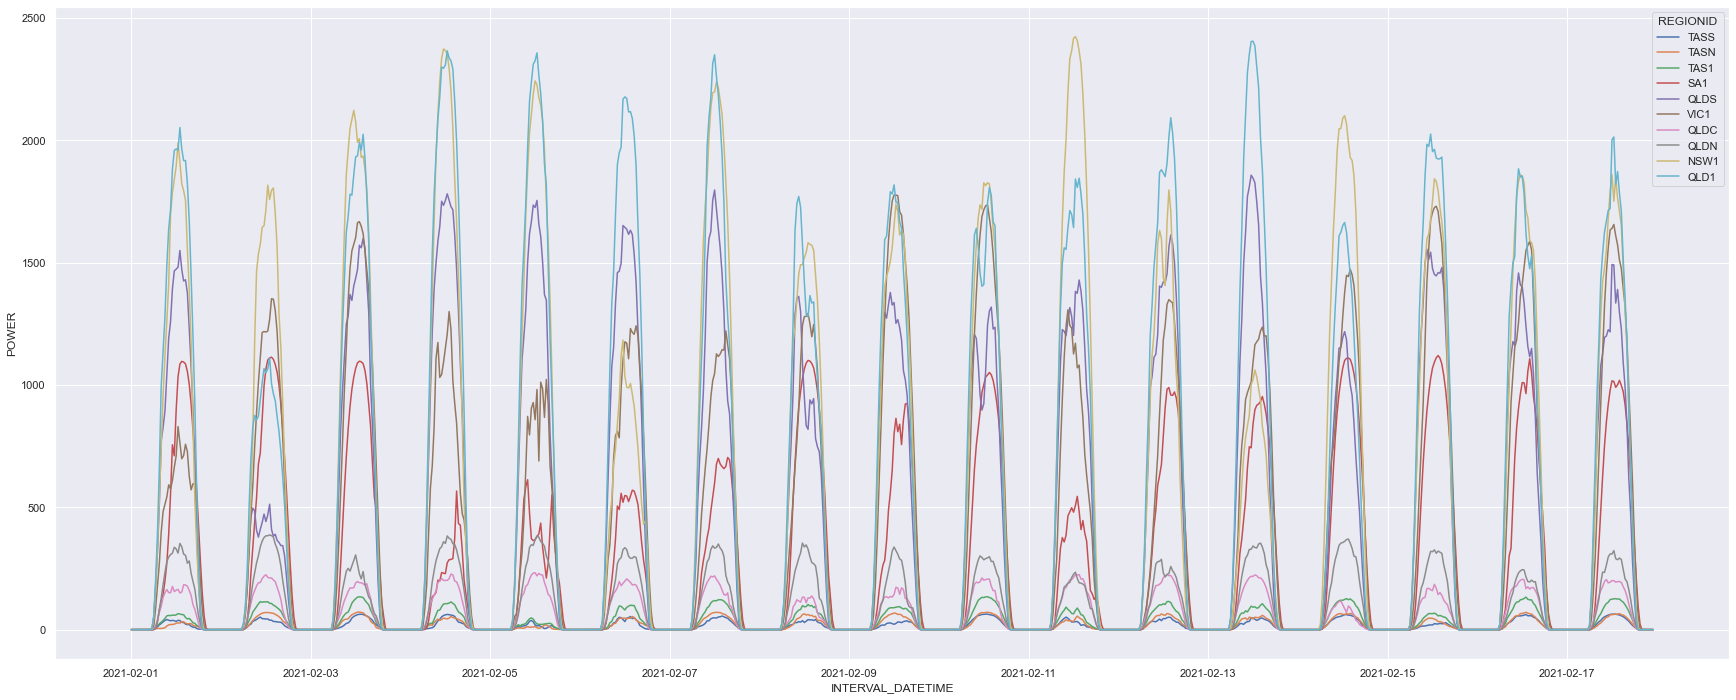

In [75]:
sns.set(rc={"figure.figsize": (30,12)})
sns.lineplot(x='INTERVAL_DATETIME', y='POWER', hue='REGIONID', data=measurement_merge_df[(measurement_merge_df.INTERVAL_DATETIME >= '2021-02-01') & (measurement_merge_df.INTERVAL_DATETIME <= '2021-03-01')])